In [ ]:
#@title Install { display-mode: "form" }

!pip install piper-tts
!pip install python-dotenv
!pip install gTTS
!pip install pydub
!pip install auto-editor
from IPython.display import clear_output
clear_output()
import time
time.sleep(10)

import os
os.kill(os.getpid(), 9)

In [ ]:


from IPython.display import clear_output

eleven_labs_api = 'sbdfk937947039hjkahsdfkjahfsd98'  # @param {type: "string"}
eleven_labs_api=f"""one='{eleven_labs_api}'"""

with open("/content/.env", "w") as env_file:
    env_file.write(eleven_labs_api)

from dotenv import dotenv_values

config = dotenv_values(".env")
api_keys=[]
for i in config:
  api_keys.append(config[i])


######################################



import os
import subprocess
import requests
import json
import re
import uuid
from gtts import gTTS
from pydub import AudioSegment
class Colab_TTS:
    def __init__(self, json_path):
        if not os.path.exists("/content/colab_tts/"):
            os.mkdir("/content/colab_tts/")

        self.json_path = json_path
        self.download_model_list(self.json_path)
    @staticmethod
    def download_model_list(output_file):
      url = "https://huggingface.co/rhasspy/piper-voices/raw/v1.0.0/voices.json"
      response = requests.get(url)
      if response.status_code == 200:
          with open("/content/voices.json", "wb") as file:
              file.write(response.content)
          print("Download successful. File saved as voices.json")
      else:
          print(f"Failed to download. Status code: {response.status_code}")
      with open("/content/voices.json", 'r', encoding='utf-8') as f:
          data = json.load(f)
      ### Only keep available high quality voice models
      keys = data.keys()
      filtered_keys = set()

      for key in keys:
          parts = key.split('-')
          language = parts[0]
          voice_name = parts[1]
          quality = parts[-1]  # Use the last part to get the quality

          # Check if there is a higher quality version already in the set
          if voice_name in filtered_keys:
              if quality == 'high':
                  # If 'high' quality is found, remove the existing versions
                  filtered_keys.discard(voice_name)
              elif quality == 'medium' and voice_name + '-high' not in filtered_keys:
                  # If 'medium' quality is found and 'high' is not present, remove existing versions
                  filtered_keys.discard(voice_name)
              elif quality == 'low' and voice_name + '-high' not in filtered_keys and voice_name + '-medium' not in filtered_keys:
                  # If 'low' quality is found and 'high' and 'medium' are not present, remove existing versions
                  filtered_keys.discard(voice_name)

          # Add the current key to the set
          filtered_keys.add(key)
      result_data = {}
      for i in filtered_keys:
          voice_model = data[i]
          voice_name = voice_model['name']
          name_english = voice_model['language']['name_english']
          country_english=voice_model['language']['country_english']

          unique_code=f"{name_english} ({name_english}, {country_english})"

          if unique_code not in result_data:
              result_data[unique_code] = {}

          result_data[unique_code][voice_name] = {
              "model_name": i,
              # Add other relevant information from voice_model if needed
          }

      with open(output_file, 'w', encoding='utf-8') as f:
          json.dump(result_data, f, indent=2)
      print(f"New file save at {output_file}")

    @staticmethod
    def tts_file_name(text):
        if text.endswith("."):
            text = text[:-1]
        text = text.lower()
        text = text.strip()
        text = re.sub('[^a-z]+', '_', text)
        truncated_text = text[:25] if len(text) > 25 else text if len(text) > 0 else "empty"
        random_string = uuid.uuid4().hex[:8].upper()
        file_name = f"/content/colab_tts/{truncated_text}_{random_string}.wav"
        return file_name

    def piper_tts(self, text, model_name, speed, silence, save_path=''):
        root=os.getcwd()
        if os.getcwd() != "/content/":
            os.chdir("/content/")
        # print(os.getcwd())
        if len(save_path)==0:  # Use the provided parameter instead of self.save_path
            output_file = self.tts_file_name(text)
        else:
            output_file = save_path  # Use the provided parameter
        if speed==None and silence==None:
          command = f'echo "{text}" | piper --model {model_name} --output_file {output_file}  --debug'
        elif speed==None and silence!=None:
          command = f'echo "{text}" | piper --model {model_name} --sentence-silence {silence} --output_file {output_file} --debug'
        elif speed!=None and silence==None:
          command = f'echo "{text}" | piper --model {model_name} --length-scale {1/float(speed)}  --output_file {output_file} --debug'
        else:
          command = f'echo "{text}" | piper --model {model_name} --length-scale {1/float(speed)} --sentence-silence {silence} --output_file {output_file} --debug'
        print(command)
        result = subprocess.run(command, shell=True)


        if os.getcwd() != root:
            os.chdir(root)
        if result.returncode == 0:
            print("TTS Generated Successfully!")
            return output_file
        else:
            print(f"Command failed with return code {result.returncode}")
            return None

    def ai_tts(self,text,voice_name,save_path=''):
        global api_keys
        file_name=None
        voice={'Thomas':'GBv7mTt0atIp3Br8iCZE','Matthew':'Yko7PKHZNXotIFUBG7I9','Antoni':'ErXwobaYiN019PkySvjV'}
        url = f'https://api.elevenlabs.io/v1/text-to-speech/{voice[voice_name]}/stream'


        headers = {
            'accept': '*/*',
            'xi-api-key': '',
            'Content-Type': 'application/json'
        }
        data = {
            "text": text,
            "voice_settings": {
                "stability": 0.5,
                "similarity_boost": 0
            }
        }
        if len(save_path)==0:  # Use the provided parameter instead of self.save_path
            output_file = self.tts_file_name(text)
        else:
            output_file = save_path  # Use the provided parameter
        for api_key in api_keys:
            headers['xi-api-key'] = api_key
            response = requests.post(url, headers=headers, json=data)

            if response.ok:
                # Save the audio file
                if len(save_path)==0:
                    file_name = self.tts_file_name(text)
                else:
                  file_name=save_path
                with open(file_name, 'wb') as f:
                    f.write(response.content)
                print("Generating tts")
                return file_name
            else:
                print("tts api failed")
                return None
    def google_tts(self,text,lang='en',save_path=''):
      if lang=='en':
        tts = gTTS(text,lang=lang,tld='us')
      else:
        tts = gTTS(text,lang=lang)
      mp3_file = '/content/temp.mp3'
      tts.save(mp3_file)
      if len(save_path)==0:
        wav_file = self.tts_file_name(text)
      else:
        wav_file = save_path
      audio = AudioSegment.from_mp3(mp3_file)
      audio.export(wav_file, format="wav")
      return wav_file

###############visualize
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
def visualize_audio(audio_file_path):
  # Check the file extension
  if audio_file_path.endswith('.mp3'):
      audio_data, sr = librosa.load(audio_file_path, sr=None)
  elif audio_file_path.endswith('.wav'):
      audio_data, sr = librosa.load(audio_file_path, sr=None)
  else:
      raise ValueError("Unsupported audio file format. Please provide a .mp3 or .wav file.")

  # Plot the waveform
  plt.figure(figsize=(10, 1))
  librosa.display.waveshow(audio_data, sr=sr)
  plt.title('Waveform')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.show()



model_json_path="/content/best_quality.json"
tts_obj=Colab_TTS(model_json_path)

clear_output()
from IPython.display import display
import json
import ipywidgets as widgets

# Function to update the available voices based on the selected language
def update_voices(change):
    selected_language = change.new
    if selected_language in voice_info:
        voice_names.options = voice_info[selected_language]
        voice_names.value = voice_info[selected_language][0]


print("PIPER TTS config")
with open(model_json_path, 'r', encoding='utf-8') as f:
    read_data = json.load(f)
# Extracting language names, voice names, and model names
languages = list(read_data.keys())
voice_info = {lang: list(read_data[lang].keys()) for lang in languages}
model_info = {lang: {voice: read_data[lang][voice]["model_name"] for voice in voice_info[lang]} for lang in languages}

# Create and display the language dropdown
sorted_language_list = sorted(languages, key=lambda x: x.split(' ')[0])
language_name = widgets.Dropdown(options=sorted_language_list, value='English (English, United States)')
display(language_name)

# Create and display the initial voice dropdown
initial_language = language_name.value
initial_voices = voice_info.get(initial_language, [])
# can i sort initial_voices alphabaticaly base on first chartecter
sorted_initial_voices = sorted(initial_voices)
voice_names = widgets.Dropdown(options=sorted_initial_voices, value='ryan')
display(voice_names)
# Attach the callback function to the language dropdown's observe method
language_name.observe(update_voices, names='value')

PIPER TTS config


Dropdown(index=7, options=('Arabic (Arabic, Jordan)', 'Catalan (Catalan, Spain)', 'Chinese (Chinese, China)', …

Dropdown(index=11, options=('amy', 'arctic', 'danny', 'hfc_male', 'joe', 'kathleen', 'kusal', 'l2arctic', 'les…

echo "Parkour deer performing stunts in zero gravity." | piper --model en_US-ryan-high --length-scale 1.1111111111111112  --output_file /content/piper.wav --debug
TTS Generated Successfully!
Language : English (English, United States)
Voice Name : ryan
Voice Model Name : en_US-ryan-low
TTS Save at : /content/piper.wav


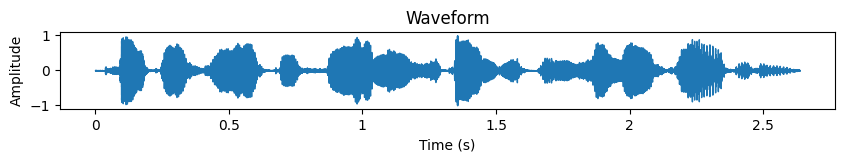

In [ ]:
#@title Piper TTS { display-mode: "form" }
Enter_text = "Parkour deer performing stunts in zero gravity."  # @param {type: "string"}
model_name=model_info[language_name.value][voice_names.value]
speed = '0.9'  # @param {type: "string"}
silence =''  # @param {type: "string"}
save_path = '/content/piper.wav'  # @param {type: "string"}
# print(f"tts_obj.piper_tts('{Enter_text}', '{model_name}', {speed}, {silence}, '{save_path}')")
if len(speed)==0:
  speed=None
else:
  speed=float(speed)
  if speed==0:
    speed=1
if len(silence)==0:
  silence=None
else:
  speed=float(silence)

# tts_save_path=tts_obj.piper_tts(Enter_text, model_name, speed, silence, save_path)
tts_save_path=tts_obj.piper_tts(Enter_text, "en_US-ryan-high", speed, silence, save_path)
print(f"Language : {language_name.value}")
print(f"Voice Name : {voice_names.value}")
print(f"Voice Model Name : {model_name}")
print(f"TTS Save at : {tts_save_path}")
visualize_audio(tts_save_path)
from IPython.display import Audio
Audio(tts_save_path,autoplay=True)


In [ ]:
#@title Download the TTS file{ display-mode: "form" }

from google.colab import files
if tts_save_path!=None:
  files.download(tts_save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating tts


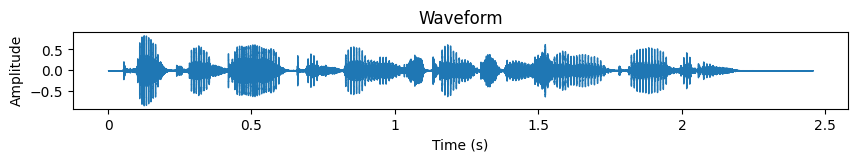

In [ ]:
#@title Eleven Labs { display-mode: "form" }
Enter_text = "Parkour deer performing stunts in zero gravity."  # @param {type: "string"}

voice_name = "Thomas" # @param ['Thomas','Matthew', 'Antoni']
save_path = '/content/eleven_labs.wav'  # @param {type: "string"}
ele_tts_save_path=tts_obj.ai_tts(Enter_text, voice_name,save_path)

visualize_audio(ele_tts_save_path)
from IPython.display import Audio
Audio(ele_tts_save_path,autoplay=True)

In [ ]:
#@title Download the TTS file{ display-mode: "form" }

from google.colab import files
if ele_tts_save_path!=None:
  files.download(ele_tts_save_path)

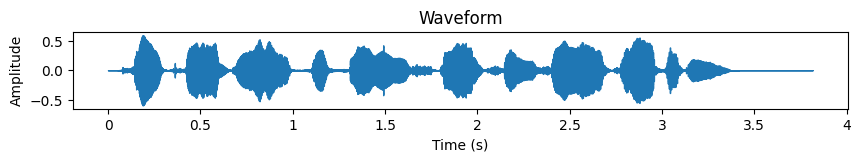

In [ ]:
#@title Google TTS { display-mode: "form" }
Enter_text = 'Parkour deer performing stunts in zero gravity.'  # @param {type: "string"}
lang  = "en" # @param ["en", "bn", "hi"] {allow-input: true}
save_path = '/content/gtts.wav'  # @param {type: "string"}
tts_save_path=tts_obj.google_tts(Enter_text,lang,save_path)
visualize_audio(tts_save_path)
from IPython.display import Audio
Audio(tts_save_path,autoplay=True)

In [ ]:
#@title Download the TTS file{ display-mode: "form" }

from google.colab import files
if tts_save_path!=None:
  files.download(tts_save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Service available!
Audio file saved successfully as '/content/tiktok.mp3'


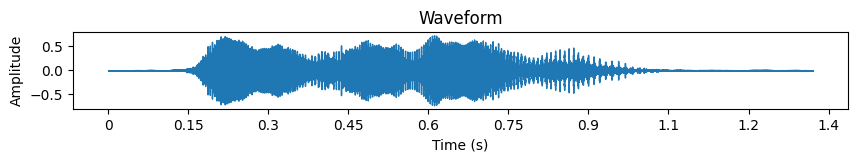

In [ ]:
#@title TikTok TTS { display-mode: "form" }
#use mp3
# https://github.com/Giooorgiooo/TikTok-Voice-TTS/blob/main/tiktokvoice.py
# author: GiorDior aka Giorgio
# date: 12.06.2023
# topic: TikTok-Voice-TTS
# version: 1.0
# credits: https://github.com/oscie57/tiktok-voice

import threading, requests, base64

VOICES = [
    # DISNEY VOICES
    'en_us_ghostface',            # Ghost Face
    'en_us_chewbacca',            # Chewbacca
    'en_us_c3po',                 # C3PO
    'en_us_stitch',               # Stitch
    'en_us_stormtrooper',         # Stormtrooper
    'en_us_rocket',               # Rocket

    # ENGLISH VOICES
    'en_au_001',                  # English AU - Female
    'en_au_002',                  # English AU - Male
    'en_uk_001',                  # English UK - Male 1
    'en_uk_003',                  # English UK - Male 2
    'en_us_001',                  # English US - Female (Int. 1)
    'en_us_002',                  # English US - Female (Int. 2)
    'en_us_006',                  # English US - Male 1
    'en_us_007',                  # English US - Male 2
    'en_us_009',                  # English US - Male 3
    'en_us_010',                  # English US - Male 4

    # EUROPE VOICES
    'fr_001',                     # French - Male 1
    'fr_002',                     # French - Male 2
    'de_001',                     # German - Female
    'de_002',                     # German - Male
    'es_002',                     # Spanish - Male

    # AMERICA VOICES
    'es_mx_002',                  # Spanish MX - Male
    'br_001',                     # Portuguese BR - Female 1
    'br_003',                     # Portuguese BR - Female 2
    'br_004',                     # Portuguese BR - Female 3
    'br_005',                     # Portuguese BR - Male

    # ASIA VOICES
    'id_001',                     # Indonesian - Female
    'jp_001',                     # Japanese - Female 1
    'jp_003',                     # Japanese - Female 2
    'jp_005',                     # Japanese - Female 3
    'jp_006',                     # Japanese - Male
    'kr_002',                     # Korean - Male 1
    'kr_003',                     # Korean - Female
    'kr_004',                     # Korean - Male 2

    # SINGING VOICES
    'en_female_f08_salut_damour',  # Alto
    'en_male_m03_lobby',           # Tenor
    'en_female_f08_warmy_breeze',  # Warmy Breeze
    'en_male_m03_sunshine_soon',   # Sunshine Soon

    # OTHER
    'en_male_narration',           # narrator
    'en_male_funny',               # wacky
    'en_female_emotional',         # peaceful
]

ENDPOINTS = ['https://tiktok-tts.weilnet.workers.dev/api/generation', "https://tiktoktts.com/api/tiktok-tts"]
current_endpoint = 0
# in one conversion, the text can have a maximum length of 300 characters
TEXT_BYTE_LIMIT = 300

# create a list by splitting a string, every element has n chars
def split_string(string: str, chunk_size: int) -> list[str]:
    words = string.split()
    result = []
    current_chunk = ''
    for word in words:
        if len(current_chunk) + len(word) + 1 <= chunk_size:  # Check if adding the word exceeds the chunk size
            current_chunk += ' ' + word
        else:
            if current_chunk:  # Append the current chunk if not empty
                result.append(current_chunk.strip())
            current_chunk = word
    if current_chunk:  # Append the last chunk if not empty
        result.append(current_chunk.strip())
    return result

# checking if the website that provides the service is available
def get_api_response() -> requests.Response:
    url = f'{ENDPOINTS[current_endpoint].split("/a")[0]}'
    response = requests.get(url)
    return response

# saving the audio file
def save_audio_file(base64_data: str, filename: str = "output.mp3") -> None:
    audio_bytes = base64.b64decode(base64_data)
    with open(filename, "wb") as file:
        file.write(audio_bytes)

# send POST request to get the audio data
def generate_audio(text: str, voice: str) -> bytes:
    url = f'{ENDPOINTS[current_endpoint]}'
    headers = {'Content-Type': 'application/json'}
    data = {'text': text, 'voice': voice}
    response = requests.post(url, headers=headers, json=data)
    return response.content

# creates an text to speech audio file
def tts(text: str, voice: str = "none", filename: str = "output.mp3", play_sound: bool = False) -> None:
    # checking if the website is available
    global current_endpoint

    if get_api_response().status_code == 200:
        print("Service available!")
    else:
        current_endpoint = (current_endpoint + 1) % 2
        if get_api_response().status_code == 200:
            print("Service available!")
        else:
            print(f"Service not available and probably temporarily rate limited, try again later...")
            return

    # checking if arguments are valid
    if voice == "none":
        print("No voice has been selected")
        return

    if not voice in VOICES:
        print("Voice does not exist")
        return

    if len(text) == 0:
        print("Insert a valid text")
        return

    # creating the audio file
    try:
        if len(text) < TEXT_BYTE_LIMIT:
            audio = generate_audio((text), voice)
            if current_endpoint == 0:
                audio_base64_data = str(audio).split('"')[5]
            else:
                audio_base64_data = str(audio).split('"')[3].split(",")[1]

            if audio_base64_data == "error":
                print("This voice is unavailable right now")
                return

        else:
            # Split longer text into smaller parts
            text_parts = split_string(text, 299)
            audio_base64_data = [None] * len(text_parts)

            # Define a thread function to generate audio for each text part
            def generate_audio_thread(text_part, index):
                audio = generate_audio(text_part, voice)
                if current_endpoint == 0:
                    base64_data = str(audio).split('"')[5]
                else:
                    base64_data = str(audio).split('"')[3].split(",")[1]

                if audio_base64_data == "error":
                    print("This voice is unavailable right now")
                    return "error"

                audio_base64_data[index] = base64_data

            threads = []
            for index, text_part in enumerate(text_parts):
                # Create and start a new thread for each text part
                thread = threading.Thread(target=generate_audio_thread, args=(text_part, index))
                thread.start()
                threads.append(thread)

            # Wait for all threads to complete
            for thread in threads:
                thread.join()

            # Concatenate the base64 data in the correct order
            audio_base64_data = "".join(audio_base64_data)

        save_audio_file(audio_base64_data, filename)
        print(f"Audio file saved successfully as '{filename}'")


    except Exception as e:
        print("Error occurred while generating audio:", str(e))

text = "Hi how are you"  # @param {type: "string"}
# voice = "en_us_002"  # @param {type: "string"}
voice ="male"  # @param ['male', 'female']
if voice =="male":
  tiktok_model="en_us_006"
if voice =="female":
  tiktok_model="en_us_001"
# arguments:
#   - input text
#   - vocie which is used for the audio
#   - output file name
#   - play sound after generating the audio

tiktok_save_path='/content/tiktok.mp3'  # @param {type: "string"}
tts(text, tiktok_model, tiktok_save_path, play_sound=True)
visualize_audio(tiktok_save_path)
from IPython.display import Audio
Audio(tiktok_save_path,autoplay=True)

In [ ]:
#@title download tiktok tts

from google.colab import files
if tiktok_save_path!=None:
  files.download(tiktok_save_path)

In [ ]:
tts_save_path

Scanning /content/gtts.wav 

Audio duration 1.392 seconds
Original Video save at '/content/temp.mp4'
slience video save at '/content/temp_ALTERED.mp4'
audio save at /content/new.wav
New Audio duration 1.408005 seconds


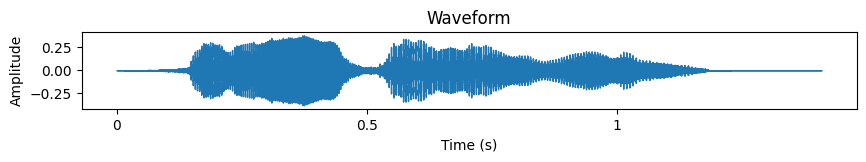

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title remove silence from audio --margin 0.2sec
#@title remove silence functions
import os
import subprocess
import re

def remove_silence_from_audio(audio_file,new_save_path):
  print(f"Scanning {audio_file} \n")
  if os.path.exists(new_save_path):
    print(f"Deleting old {new_save_path}")
    os.remove(new_save_path)
  curr=os.getcwd()
  os.chdir("/content/")
  # Use ffprobe to get the duration of the audio

  try:
    ffprobe_command = f"ffprobe -i {audio_file} -show_entries format=duration -v quiet -of csv=p=0"
    duration_string = subprocess.check_output(ffprobe_command, shell=True, text=True)
    duration = float(duration_string)
    print(f"Audio duration {duration} seconds")
    # ffmpeg_command=f"ffmpeg -f lavfi -t {duration} -i color=c=white:s=160x90 -c:v libx264 -strict experimental '/content/blank.mp4' -y"
    ffmpeg_command=f"ffmpeg -f lavfi -t {duration} -i color=c=black:s=160x90 -c:v libx264 -strict experimental '/content/blank.mp4' -y"

    white_var=os.system(ffmpeg_command)
    if white_var==0:
      response_var=os.system(f"ffmpeg -i '/content/blank.mp4' -i {audio_file} -map 0 -map 1 -c:v copy -c:a aac -strict experimental temp.mp4 -y")
      if response_var==0:
        print("Original Video save at '/content/temp.mp4'")
        margin= '0.1'  # @param {type: "string"}
        var=os.system(f"auto-editor '/content/temp.mp4' --margin {float(margin)}sec")
        # var1=os.system(f"auto-editor {my_db[video_id]} --margin 0.2sec")
        if var==0:
          final_var=os.system(f"ffmpeg -i '/content/temp_ALTERED.mp4' -vn -acodec pcm_s16le -ar 44100 -ac 2 {new_save_path} -y")
          if final_var==0:
            print(f"slience video save at '/content/temp_ALTERED.mp4'")
            print(f"audio save at {new_save_path}")
          else:
            print(f"Failed to remove silence from audio")
        else:
          print("failed to edit video")
      else:
        print("Can't add audio in blank video")
    else:
      print("Can't create blank video")
  except Exception as e:
    print(e)
    print("Can't find audio duration")
  os.chdir(curr)
#@title remove silence
# target_audio_path=tts_save_path
target_audio_path = '/content/ele.mp3'  # @param {type: "string"}
new_save_path='/content/new.wav'  # @param {type: "string"}
remove_silence_from_audio(target_audio_path,new_save_path)
ffprobe_command = f"ffprobe -i {new_save_path} -show_entries format=duration -v quiet -of csv=p=0"
duration_string = subprocess.check_output(ffprobe_command, shell=True, text=True)
duration = float(duration_string)
print(f"New Audio duration {duration} seconds")
visualize_audio(new_save_path)


#@title Download audio after remove silence { display-mode: "form" }
from google.colab import files
if new_save_path!=None:
  files.download(new_save_path)

from IPython.display import Audio
Audio(new_save_path,autoplay=False)